<h1><b>Question 1</b></h1>
<h3>Decision Tree from Scratch</h3>

In [112]:
#importing required modules and functions
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

#dropping unnecessary columns
colsToDrop = ['PassengerId', 'Ticket', 'Cabin']
df.drop(columns = colsToDrop, inplace=True)

#this mean won't be used to fill in nan values
print(df['Age'].mean())

df = df[df['Embarked'].notna()].copy()
df.isna().sum()

29.69911764705882


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [114]:
#design matrix
x = df[['Pclass', 'Name', 'Sex', 'Age', 'Fare', 'Embarked']]
#true class labels
y = df['Survived']
x

,Pclass,Name,Sex,Age,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,8.0500,S
...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,13.0000,S
887,1,"Graham, Miss. Margaret Edith",female,19.0,30.0000,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,23.4500,S
889,1,"Behr, Mr. Karl Howell",male,26.0,30.0000,C


In [115]:
#creating a boolean mask based on pclass and gender
def masking(pclass, sex, bool_mask_master, X_set):
    return ((X_set['Pclass'] == pclass) & (X_set['Sex'] == sex) & ~(bool_mask_master))


In [116]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=9872, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.67, random_state=9872, stratify=y_test)
x_train

,Pclass,Name,Sex,Age,Fare,Embarked
433,3,"Kallio, Mr. Nikolai Erland",male,17.0,7.1250,S
15,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,16.0000,S
339,1,"Blackwell, Mr. Stephen Weart",male,45.0,35.5000,S
393,1,"Newell, Miss. Marjorie",female,23.0,113.2750,C
33,2,"Wheadon, Mr. Edward H",male,66.0,10.5000,S
...,...,...,...,...,...,...
306,1,"Fleming, Miss. Margaret",female,NaN,110.8833,C
187,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,26.5500,S
350,3,"Odahl, Mr. Nils Martin",male,23.0,9.2250,S
340,2,"Navratil, Master. Edmond Roger",male,2.0,26.0000,S


In [118]:
def apply_preprocessing(X_set):

    bool_mask_master = X_set['Name'].str.contains('Master')
    #filtering out names having 'Master' as they are children. Calculating average age
    #for them separately as it might be more accurate, because having an average age > 18
    #for children makes no sense
    master_name = X_set[bool_mask_master].copy()

    #calculating mean age of the children
    master_mean = master_name['Age'].mean()
    print(f'{master_mean}\n')

    #filling up nan ages of children
    master_name['Age'].fillna(master_mean, inplace=True)

    #setting the modified values to the design matrix
    X_set.loc[bool_mask_master] = master_name
    X_set[bool_mask_master]

    #following lines of code calculate mean age based on pclass and sex and fills in nan values accordingly
    male_filtered = []
    for i in range(3):
        male_filtered.append(X_set[masking((i+1), 'male', bool_mask_master, X_set)].copy())

    female_filtered = []
    for i in range(3):
        female_filtered.append(X_set[masking((i+1), 'female', bool_mask_master, X_set)].copy())

    male_filtered_mean = []
    for i in range(3):
        male_filtered_mean.append(male_filtered[i]['Age'].mean())
        #print(male_filtered_mean[i])

    female_filtered_mean = []
    for i in range(3):
        female_filtered_mean.append(female_filtered[i]['Age'].mean())
        #print(female_filtered_mean[i])

    for i in range(3):
        male_filtered[i]['Age'].fillna(male_filtered_mean[i], inplace=True)
        female_filtered[i]['Age'].fillna(female_filtered_mean[i], inplace=True)

        X_set.loc[masking((i+1), 'male', bool_mask_master, X_set)] = male_filtered[i]
        X_set.loc[masking((i+1), 'female', bool_mask_master, X_set)] = female_filtered[i]
    
    X_set.drop(columns = ['Name'], inplace=True)
    
    #Onehot Encoding and dropping (drop_first) the first column as 
    #information provided by one column is redundant
    X_set = pd.get_dummies(X_set, columns=['Embarked'], dtype=int, drop_first=True)
    X_set = pd.get_dummies(X_set, columns=['Pclass'], dtype=int, drop_first=True)

    #mapping genders to 1 and 0
    gender = {'male': 1, 'female': 0}
    X_set['Sex'] = X_set['Sex'].map(gender)
    print(X_set.isna().sum())

    return X_set



In [119]:
#applying data preprocessing to the 3 datasets independently. Test set should remain unseen to the model while training. Hence, pre processing done separately

x_train = apply_preprocessing(x_train)
x_val = apply_preprocessing(x_val)
x_test = apply_preprocessing(x_test)

4.122142857142857

Sex           0
Age           0
Fare          0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
dtype: int64
6.975714285714285

Sex           0
Age           0
Fare          0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
dtype: int64
0.42

Sex           0
Age           0
Fare          0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
dtype: int64


In [120]:
x_train
x_test

,Sex,Age,Fare,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
561,1,40.000000,7.8958,0,1,0,1
857,1,51.000000,26.5500,0,1,0,0
151,0,22.000000,66.6000,0,1,0,0
838,1,32.000000,56.4958,0,1,0,1
499,1,24.000000,7.7958,0,1,0,1
...,...,...,...,...,...,...,...
172,0,1.000000,11.1333,0,1,0,1
330,0,18.288462,23.2500,1,0,0,1
483,0,63.000000,9.5875,0,1,0,1
865,0,42.000000,13.0000,0,1,1,0


In [121]:
class Node:
    #in categorical data, 0 corresponds to left node and 1 corresponds to right node
    def __init__(self, X, Y):
        self.left = None
        self.right = None
        self.entropy = 0
        self.leaf = False
        self.X = X
        self.Y = Y
        self.samples = len(self.Y)
        self.datapoints = np.append(np.bincount(self.Y), 0) if np.count_nonzero(self.Y) == 0 else np.bincount(self.Y)
        self.label = np.argmax(self.datapoints) if len(self.datapoints) > 0 else None
        self.depth = 0
        #threshold_feature is the feature name based on which splitting is done
        self.threshold_feature = None
        #threshold value of split
        self.threshold = None


class DecisionTree_classifier:
    def __init__(self, x_train, y_train, max_depth=None):
        self.root = None
        self.max_depth = max_depth
        self.x_train = x_train
        self.y_train = y_train
        self.num_features = self.x_train.shape[1]
        self.index_classify = {}
        self.index_names = dict(enumerate(self.x_train.columns))
        
    
    #categorizes columns into continuous and categorical for the ease of training and evaluation
    def categorical_continuous(self):

        #setting  a threshold to determine if a column is continuous or categorical
        #if number of unique values in a column > 5% of total rows, then continuous
        for i in range(self.num_features):
            if self.x_train.iloc[:, i].nunique() > (0.05 * self.x_train.shape[0]):
                self.index_classify[i] = 'continuous'
            
            else:
                self.index_classify[i] = 'categorical'


    #returns entropy of a node
    def entropy(self, node):
        if(np.count_nonzero(node.datapoints) == 1):
            return 0.

        node_entropy = 0.
        for i in range(len(node.datapoints)):
            if node.datapoints[i] != 0:
                node_entropy = node_entropy - ((node.datapoints[i] / node.samples) * math.log2(node.datapoints[i] / node.samples))
        
        return node_entropy
    
    
    #returns information gain resulted by splitting a node a certain way
    def information_gain(self, node, left, right):
        total = node.samples
        left_total = left.samples
        right_total = right.samples

        infoGain = node.entropy - ((left_total / total) * left.entropy) - ((right_total / total) * right.entropy)
        return infoGain
    

    #transforms the continuous variables to categorical variables for binary classification
    def conTocat(self, dframe, col):
        transformed = []
        
        if(len(dframe[col]) > 0):
            for i in range(len(dframe[col]) - 1):
                curr_val = dframe[col].iloc[i]
                next_val = dframe[col].iloc[i + 1]

                transformed.append((curr_val + next_val)/2.)

        elif (len(dframe[col]) == 0):
            transformed.append(dframe[col].iloc[0])

        return transformed
    

    #recursive function to build tree by creating left and right child nodes
    def build_tree(self, node):
        
        #after each split in the tree, we calculate validation accuracy with the validation set
        print(f'Validation set accuracy: {self.score(x_val, y_val) * 100} %')

        if(node.depth == self.max_depth):
            return
        
        self.split(node)

        if(node.left != None):
            self.build_tree(node.left)

        if(node.right != None):
            self.build_tree(node.right)
        

    #called by user to train the model
    def fit(self):
        self.categorical_continuous()

        #create root node
        self.root = Node(self.x_train, self.y_train)
        self.root.entropy = self.entropy(self.root)

        self.build_tree(self.root)
        

    #performs best split, and none if not possible    
    def split(self, node):

        if(np.count_nonzero(node.datapoints) == 1):
            node.leaf = True
            return
        
        gain_list = []
        max_gain = -1
        finalLeftNode = None
        finalRightNode = None

        for i in range(self.num_features):
            if self.index_classify[i] == 'categorical':
                col_name = self.index_names[i]
                unique_val = np.sort(node.X[col_name].unique())

                if(len(unique_val) == 1):
                    gain_list.append(-1)
                    continue
                
                mask_left = node.X[col_name] == unique_val[0]
                mask_right = node.X[col_name] == unique_val[1]

                left_node = Node(node.X[mask_left], node.Y[mask_left])
                right_node = Node(node.X[mask_right], node.Y[mask_right])

                left_node.entropy = self.entropy(left_node)
                right_node.entropy = self.entropy(right_node)

                gain = self.information_gain(node, left_node, right_node)
                gain_list.append(gain)

                #keeps record of the maximum information gain obtained from categorical variables. also stores the possible left and right child nodes
                if gain > max_gain:
                    max_gain = gain
                    finalLeftNode = left_node
                    finalRightNode = right_node
                    node.threshold_feature = col_name
                    node.threshold = 1
                
            
            else:
                col_name = self.index_names[i]
                transformed = self.conTocat(node.X, col_name)

                max_gain_cont = -1
                finalLeftNode_cont = None
                finalRightNode_cont = None
                threshold_val = None

                for i in range(len(transformed)):
                    #producing masks for possible best split
                    mask_left = node.X[col_name] <= transformed[i]
                    mask_right = node.X[col_name] > transformed[i]

                    left_node = Node(node.X[mask_left], node.Y[mask_left])
                    right_node = Node(node.X[mask_right], node.Y[mask_right])

                    left_node.entropy = self.entropy(left_node)
                    right_node.entropy = self.entropy(right_node)

                    gain_cont_split = self.information_gain(node, left_node, right_node)

                    #stores details regarding highest info gain obtained from a specific continuous feature
                    if gain_cont_split > max_gain_cont:
                        max_gain_cont = gain_cont_split
                        finalLeftNode_cont = left_node
                        finalRightNode_cont = right_node
                        threshold_val = transformed[i]

                gain_list.append(max_gain_cont)

                #stores details regarding highest info gain obtained across all continuous features
                if max_gain_cont > max_gain:
                    max_gain = max_gain_cont
                    finalLeftNode = finalLeftNode_cont
                    finalRightNode = finalRightNode_cont
                    node.threshold_feature = col_name
                    node.threshold = threshold_val
                #print(gain_list_continuous)

        #if gain does not exceed 0 for any feature, splitting does not happen    
        if(max_gain <= 0):
            return        
        
        #assign left and child nodes to the current node and updating depth
        if(finalLeftNode != None and finalRightNode != None):
            node.left = finalLeftNode
            node.left.depth = node.depth + 1

            node.right = finalRightNode
            node.right.depth = node.depth + 1

        #print(gain_list)


    #prints the tree for visual reference    
    def print_tree(self, node, prefix="Root: "):
        if node != None:
            for i in range(node.depth * 4):
                print(' ', end='')
            print(f'{prefix} {node.datapoints}')
            if node.left != None or node.right != None:
                self.print_tree(node.left, "L--")
                self.print_tree(node.right, "R--")


    #recursive function to find predicted labels
    def find_predictions(self, testX, node):
        if node.left == None and node.right == None:
            return pd.Series(node.label, index=testX.index)
        
        idx = -1
        for i in range(len(self.index_names)):
            if self.index_names[i] == node.threshold_feature:
                idx = i
                break

        if self.index_classify[idx] == 'continuous':
            mask = testX[node.threshold_feature] <= node.threshold

        else:
            mask = testX[node.threshold_feature] < node.threshold

        y_pred_left = self.find_predictions(testX[mask], node.left)
        y_pred_right = self.find_predictions(testX[~mask], node.right)

        y_pred = pd.concat([y_pred_left, y_pred_right])

        return y_pred
    

    #returns predicted labels 
    def predict(self, testX, testY=pd.Series()):
        y_pred = self.find_predictions(testX, self.root)
        
        #testY = None only when we have a sample given by user from outside
        
        if(not(testY.empty)):
            y_pred = y_pred.reindex(testY.index)
        return y_pred


    #calculates fraction of correctly predicted labels
    def score(self, testX, testY):

        y_pred = self.predict(testX, testY)
        #y_pred = y_pred.reindex(testY.index)

        return np.sum(testY == y_pred)/testY.shape[0]
    

    #Accepts details of a passenger and predicts their survivability
    def infer(self):
        categories = ['Passenger ID', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
                      'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
        
        details = {}
        for name in categories:
            details[name] = input(name)
        
        details = {key: [value] for key, value in details.items()}
        details_df = pd.DataFrame(details)

        details_df['Pclass'] = details_df['Pclass'].astype(int)    
        details_df['Age'] = details_df['Age'].astype(int) 
        details_df['SibSp'] = details_df['SibSp'].astype(int)  
        details_df['Parch'] = details_df['Parch'].astype(int)
        details_df['Fare'] = details_df['Fare'].astype(float)

        print(f'Passenger Details:\n{details_df}')
        
        gender = {'male': 1, 'female': 0}
        details_df['Sex'] = details_df['Sex'].map(gender)
        
        embarked = details_df.loc[0, 'Embarked']
        if embarked == 'Q':
            details_df['Embarked_Q'] = 1
            details_df['Embarked_S'] = 0

        elif embarked == 'S':
            details_df['Embarked_Q'] = 0
            details_df['Embarked_S'] = 1

        else:
            details_df['Embarked_Q'] = 0
            details_df['Embarked_S'] = 0

        p_class = details_df.loc[0, 'Pclass']
        if p_class == 1:
            details_df['Pclass_2'] = 0
            details_df['Pclass_3'] = 0

        elif p_class == 2:
            details_df['Pclass_2'] = 1
            details_df['Pclass_3'] = 0

        else:
            details_df['Pclass_2'] = 0
            details_df['Pclass_3'] = 1

        details_df = details_df[['Sex', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3']]
        y_pred = self.predict(details_df)
        print(f'Survivability: {y_pred.iloc[0]}')

    
    #calculates and returns precision, recall, f1 score and confusion matrix
    def calculate_metrics(self, testY, y_pred):
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for actual, predicted in zip(testY, y_pred):

            if actual == 1 and predicted == 1:
                tp += 1

            elif actual == 0 and predicted == 1:
                fp += 1

            elif actual == 0 and predicted == 0:
                tn += 1

            else:
                fn += 1

        return tp, fp, tn, fn
        





User needs to create an object of class <b>DecisionTree_classifier.</b><br>
Call <b>fit()</b> to train the model with the given dataset.<br>
Call <b>print_tree()</b> to get a visual overview of the tree built.<br>
Call <b>predict()</b> to get the predictions based on a certain dataset passed as argument.<br>
Call <b>score()</b> to get fraction of correct predictions.
Call <b>infer()</b> to pass details regarding one passenger and predict whether they survived (1) or not (0)

In [122]:
tree = DecisionTree_classifier(x_train, y_train, max_depth=8)
tree.fit()

Validation set accuracy: 62.01117318435754 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.6536312849162 %
Validation set accuracy: 77.653

In [123]:
y_pred = tree.predict(x_test, y_test)
tp, fp, tn, fn = tree.calculate_metrics(y_test, y_pred)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2. * (precision * recall) / (precision + recall)

print(f'Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}')

Precision: 0.9230769230769231
Recall: 0.7058823529411765
F1 Score: 0.8000000000000002


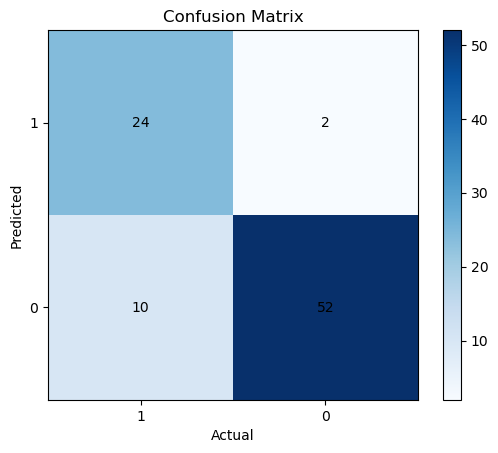

In [124]:
confusion_matrix = np.array([[tp, fp],
                             [fn, tn]])

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

classes = [1, 0]
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')

plt.savefig('pa2_q1_confusion_matrix.png')
plt.show()


In [125]:
#current result is obtained at max_depth = 6. setting max_depth = None overfits the data to the training set, resulting in higher training set accuracy but lower test set acc
print(f'Training Set Accuracy: {tree.score(x_train, y_train) * 100} %')
print(f'Test Set Accuracy: {tree.score(x_test, y_test) * 100} %')

Training Set Accuracy: 88.2636655948553 %
Test Set Accuracy: 86.36363636363636 %


<h4>Results obtained for max_depth = None</h4>
<p>Training Set Accuracy: 98.07073954983923 %</br>
Test Set Accuracy: 85.22727272727273 %<p></br>
[clear signs of overfitting]

In [72]:
#using insignificant values for columns which won't be considered for training
tree.infer()

Passenger Details:
  Passenger ID  Pclass             Name   Sex  Age  SibSp  Parch Ticket  Fare  \
0       123456       3  Rishabh Acharya  male   19      1      2  abcde  10.1   

  Cabin Embarked  
0   ggg        C  
Survivability: 0


In [126]:
#displays the tree in a sort of branched manner
tree.print_tree(tree.root)

Root:  [384 238]
    L-- [ 52 155]
        L-- [  9 106]
            L-- [ 7 47]
                L-- [ 0 12]
                R-- [ 7 35]
                    L-- [ 6 35]
                        L-- [3 6]
                            L-- [1 4]
                                L-- [1 0]
                                R-- [0 4]
                            R-- [2 2]
                                L-- [0 2]
                                R-- [2 0]
                        R-- [ 3 29]
                            L-- [ 0 17]
                            R-- [ 3 12]
                                L-- [0 4]
                                R-- [3 8]
                    R-- [1 0]
            R-- [ 2 59]
                L-- [ 0 48]
                R-- [ 2 11]
                    L-- [2 1]
                        L-- [1 0]
                        R-- [1 1]
                            L-- [0 1]
                            R-- [1 0]
                    R-- [ 0 10]
        R-- [43 49]
            L-- [

<h1><b>Question 2</b></h1>
<h3>Linear Regression</h3>

In [127]:
df = pd.read_csv('https://raw.githubusercontent.com/devzohaib/Simple-Linear-Regression/master/tvmarketing.csv')
df
#no missing values!!
#df.isna().sum()

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9
...,...,...
195,38.2,7.6
196,94.2,9.7
197,177.0,12.8
198,283.6,25.5


In [128]:
x = df['TV']
y = df['Sales']

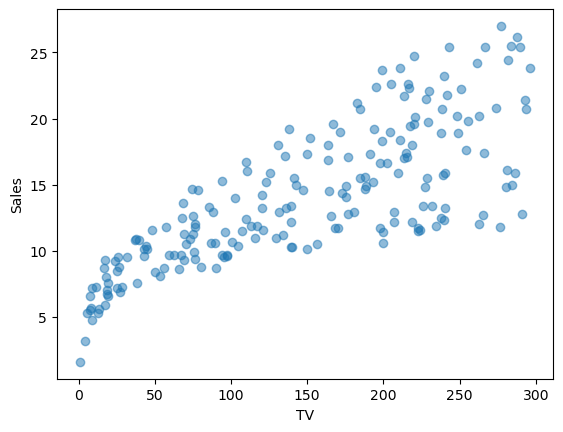

In [129]:
plt.xlabel('TV')
plt.ylabel('Sales')
plt.scatter(x, y, alpha=0.5)
plt.savefig('pa2_q2_scatter.png')
plt.show()

In [130]:
tv_mean = x.mean()
tv_std = x.std()

sales_mean = y.mean()
sales_std = y.std()

print(f'TV:\nMean: {tv_mean}\nStandard Deviation: {tv_std}\n\nSales:\nMean: {sales_mean}\nStandard Deviation: {sales_std}')

TV:
Mean: 147.0425
Standard Deviation: 85.8542363149081

Sales:
Mean: 14.0225
Standard Deviation: 5.217456565710477


In [131]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=3)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#z normalization of data
mean_x = np.mean(x_train)
std_x = np.std(x_train)
x_train = (x_train - mean_x) / std_x
x_test = (x_test - mean_x) / std_x

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y

#generalising it as a 2D array so that batch gradient descent can be applied later
x_train = x_train.reshape(len(x_train), 1)
x_test = x_test.reshape(len(x_test), 1)

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)


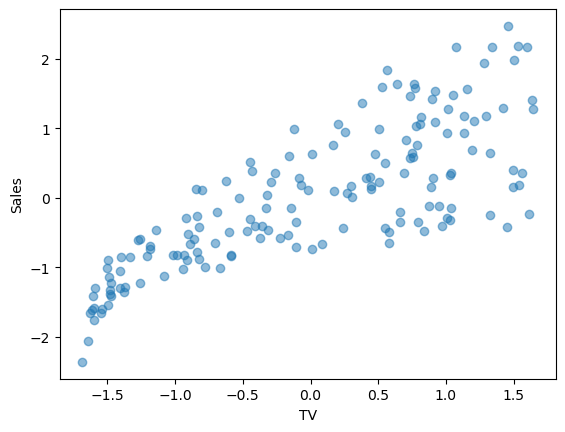

In [132]:
plt.xlabel('TV')
plt.ylabel('Sales')
plt.scatter(x_train, y_train, alpha= 0.5)
plt.savefig('pa2_q2_scatter_normalised_training.png')
plt.show()

<h3><b>I made a general model of Linear Regression which I will use for Q3's multivariate Linear Regression problem as well</b></h3>

In [133]:
#MSE = (1/n)*(yhat - (weight.x + bias))^2
#d(loss)/d(bias) = -2*(yhat - y)/n
#d(loss)/d(weight) = -2*x*(yhat - y)/n

class Linear_Regression():
    def __init__(self, *, num_features):
        self.num_features = num_features
        self.weights = np.zeros([self.num_features, 1], dtype=np.float64)
        self.bias = np.zeros(1, dtype=np.float64)
        self.cost = []

    def loss(self, yhat, y):
    #average of sum of squares (MSE)
        return np.mean((yhat - y)**2)

    def mean_abs_error(self, yhat, y):
        return np.mean(abs(yhat - y))

    def forward(self, x):
        #using the advantage of vectorization in numpy arrays
        #calculates predicted y for each sample using vectorization
        yhat = x @ self.weights + self.bias
        return yhat
    
    def backward(self, x, yhat, y):
        grad_loss_weights = (-2 * (x.T @ (yhat - y))) / y.shape[0]
        grad_loss_bias = -2 * (np.sum((yhat - y)) / y.shape[0])

        return grad_loss_weights, grad_loss_bias
    
    def train(self, *, x, y, learning_rate = 0.01, epochs = None):
        self.cost = []
        for e in range(epochs):

            yhat = self.forward(x)
            negative_grad_w, negative_grad_b = self.backward(x, yhat, y)

            self.weights += learning_rate * negative_grad_w
            self.bias += learning_rate * negative_grad_b

            curr_loss = self.loss(yhat, y)
            print(f'Epoch: {e+1}\tMSE: {curr_loss}')
            self.cost.append(curr_loss)
            
    


In [134]:
model = Linear_Regression(num_features=x_train.shape[1])
model.train(x= x_train, y = y_train, learning_rate=0.1, epochs=40)

Epoch: 1	MSE: 1.0000000000000004
Epoch: 2	MSE: 0.7744599417537192
Epoch: 3	MSE: 0.6301143044760995
Epoch: 4	MSE: 0.5377330966184228
Epoch: 5	MSE: 0.4786091235895098
Epoch: 6	MSE: 0.44076978085100543
Epoch: 7	MSE: 0.4165526014983626
Epoch: 8	MSE: 0.40105360671267115
Epoch: 9	MSE: 0.3911342500498287
Epoch: 10	MSE: 0.3847858617856096
Epoch: 11	MSE: 0.38072289329650927
Epoch: 12	MSE: 0.3781225934634851
Epoch: 13	MSE: 0.37645840157034954
Epoch: 14	MSE: 0.37539331875874293
Epoch: 15	MSE: 0.37471166575931464
Epoch: 16	MSE: 0.3742754078396805
Epoch: 17	MSE: 0.37399620277111467
Epoch: 18	MSE: 0.3738175115272325
Epoch: 19	MSE: 0.37370314913114794
Epoch: 20	MSE: 0.37362995719765385
Epoch: 21	MSE: 0.3735831143602176
Epoch: 22	MSE: 0.3735531349442584
Epoch: 23	MSE: 0.3735339481180445
Epoch: 24	MSE: 0.37352166854926766
Epoch: 25	MSE: 0.3735138096252505
Epoch: 26	MSE: 0.37350877991387943
Epoch: 27	MSE: 0.373505560898602
Epoch: 28	MSE: 0.37350350072882443
Epoch: 29	MSE: 0.3735021822201668
Epoch: 30	MS

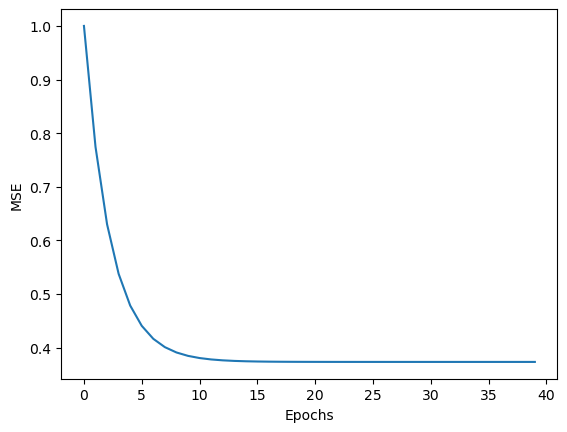

In [135]:
cost = model.cost
plt.plot(range(len(cost)), cost)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.savefig('pa2_q2_mse_epochs.png')
plt.show()

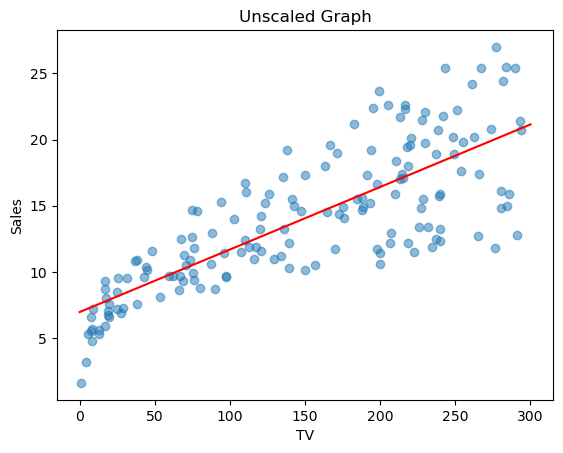

In [136]:
#Plot on original data
x_values = np.linspace(0, 300, 2)
m = model.weights[0][0] * (std_y / std_x)
c = mean_y - mean_x * m
y_values = m * x_values + c

# Plot the regression line
plt.plot(x_values, y_values, color='red', label='Regression Line')
plt.title('Unscaled Graph')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.scatter(x_train*std_x + mean_x, y_train*std_y + mean_y, alpha= 0.5)
plt.savefig('pa2_q2_fit_unscaled_training.png')
plt.show()

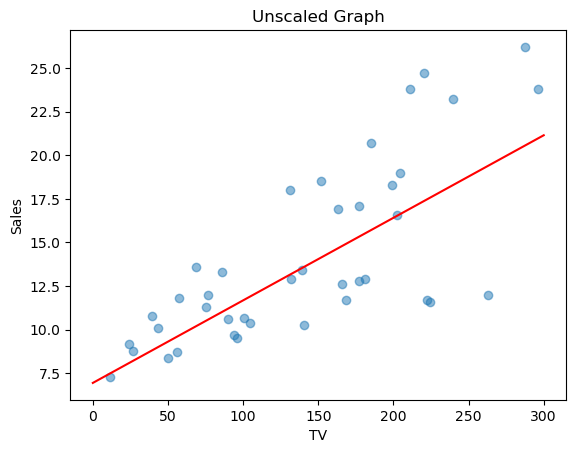

In [137]:
#Plot on original data
x_values = np.linspace(0, 300, 2)
m = model.weights[0][0] * (std_y / std_x)
c = mean_y - mean_x * m
y_values = m * x_values + c

# Plot the regression line
plt.plot(x_values, y_values, color='red', label='Regression Line')
plt.title('Unscaled Graph')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.scatter(x_test*std_x + mean_x, y_test*std_y + mean_y, alpha= 0.5)
plt.savefig('pa2_q2_fit_unscaled_test.png')
plt.show()

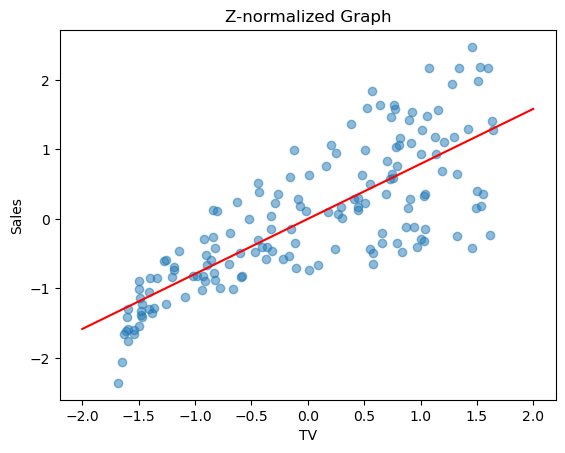

In [138]:
#Plot on standardised data
x_values = np.linspace(-2, 2, 2)
m = model.weights[0][0]
c = model.bias
y_values = m * x_values + c

# Plot the regression line
plt.plot(x_values, y_values, color='red', label='Regression Line')
plt.title('Z-normalized Graph')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.scatter(x_train, y_train, alpha=0.5)
plt.savefig('pa2_q2_fit_scaled_training.png')
plt.show()

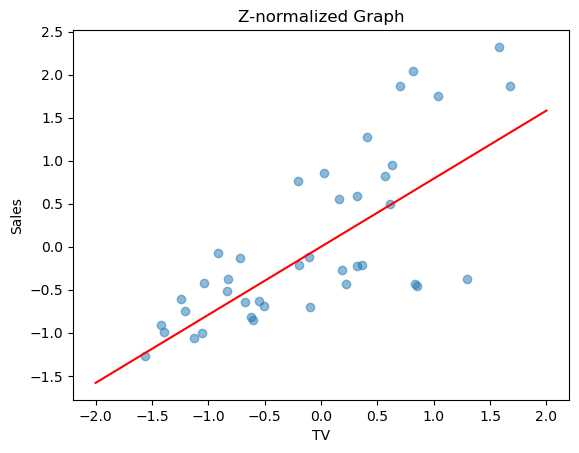

In [139]:
#Plot on standardised data
x_values = np.linspace(-2, 2, 2)
m = model.weights[0][0]
c = model.bias
y_values = m * x_values + c

# Plot the regression line
plt.plot(x_values, y_values, color='red', label='Regression Line')
plt.title('Z-normalized Graph')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.scatter(x_test, y_test, alpha=0.5)
plt.savefig('pa2_q2_fit_scaled_test.png')
plt.show()

In [140]:
y_pred = model.forward(x_test)
print(f'Test MSE: {model.loss(y_pred, y_test)}')
print(f'Test Mean Absolute Error (MAE): {model.mean_abs_error(y_pred, y_test)}')

Test MSE: 0.4125772567595091
Test Mean Absolute Error (MAE): 0.5101535646116397


<h1><b>Question 3</b></h1>
<h3>Multivariate Linear Regression</h3>

 <b>CRIM</b>: &nbsp; per capita crime rate by town<br>
 <b>ZN</b>: &nbsp;       proportion of residential land zoned for lots over 25,000 sq.ft.<br>
 <b>INDUS</b>: &nbsp;    proportion of non-retail business acres per town<br>
 <b>CHAS</b> : &nbsp;    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)<br>
 <b>NOX</b> : &nbsp;     nitric oxides concentration (parts per 10 million)<br>
 <b>RM</b>   : &nbsp;    average number of rooms per dwelling<br>
 <b>AGE</b>  : &nbsp;    proportion of owner-occupied units built prior to 1940<br>
 <b>DIS</b>   : &nbsp;   weighted distances to five Boston employment centres<br>
 <b>RAD</b>   : &nbsp;   index of accessibility to radial highways<br>
 <b>TAX</b>   : &nbsp;   full-value property-tax rate per $10,000<br>
 <b>PTRATIO</b>: &nbsp;  pupil-teacher ratio by town<br>
 <b>B</b>   : &nbsp;     1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
 <b>LSTAT</b> : &nbsp;   % lower status of the population<br>
 <b>MEDV</b>  : &nbsp;   Median value of owner-occupied homes in $1000's<br>

In [141]:
df = pd.read_csv('http://lib.stat.cmu.edu/datasets/boston', sep="\s+", skiprows=22, header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90000,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,0.10959,0.00,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0
1009,393.45000,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,0.04741,0.00,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0


In [142]:
df[[11, 12, 13]] = ''
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,,,
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,,,
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90000,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
1008,0.10959,0.00,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,,,
1009,393.45000,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
1010,0.04741,0.00,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,,,


In [143]:
for i in range(1,1012,2):
    
    df.at[i-1, 11] = df.at[i, 0]
    df.at[i-1, 12] = df.at[i, 1]
    df.at[i-1, 13] = df.at[i, 2]

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98,24.0
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90000,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
1008,0.10959,0.00,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
1009,393.45000,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,
1010,0.04741,0.00,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.9,7.88,11.9


In [144]:
df = df[df.index % 2 == 0]

In [145]:
df = df.reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.9,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.9,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [146]:
df.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64

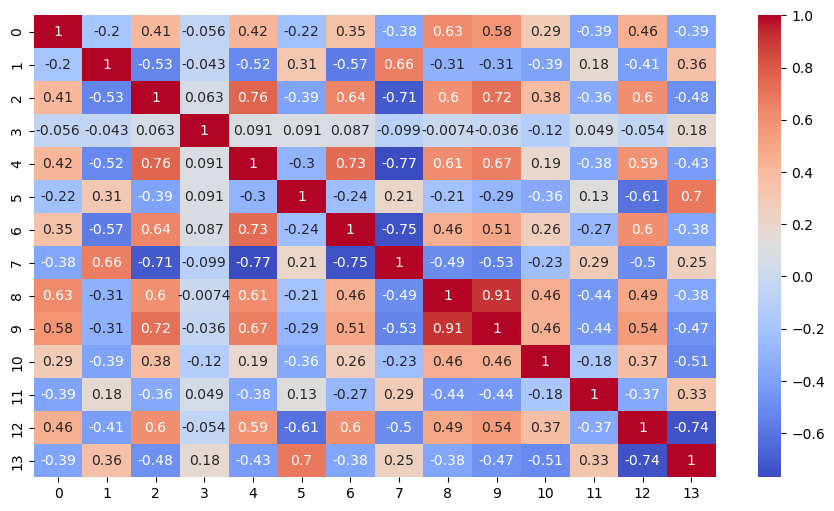

In [147]:
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.savefig('pa2_q3_correlation_heatmap.png')
plt.show()

In [148]:
x = df.iloc[:, :13]
y = df.iloc[:, 13]
x

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.9,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.9,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)
x_train = x_train.to_numpy(dtype= np.float64)
y_train = y_train.to_numpy(dtype= np.float64)
x_test = x_test.to_numpy(dtype= np.float64)
y_test = y_test.to_numpy(dtype= np.float64)


#z normalisation
mean_x = np.mean(x_train, axis=0)
std_x = np.std(x_train, axis=0)

x_train = (x_train - mean_x) / std_x
x_test = (x_test - mean_x) / std_x

mean_y = np.mean(y_train, axis=0)
std_y = np.std(y_train, axis=0)

y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y

#generalising it as a 2D array so that batch gradient descent can be applied later
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)


In [150]:
linReg = Linear_Regression(num_features= x_train.shape[1])
linReg.train(x= x_train, y = y_train, learning_rate=0.1, epochs=80)

Epoch: 1	MSE: 1.0
Epoch: 2	MSE: 0.502105243137567
Epoch: 3	MSE: 0.4084498338855842
Epoch: 4	MSE: 0.36395099468948744
Epoch: 5	MSE: 0.33831332309663403
Epoch: 6	MSE: 0.32281060303788556
Epoch: 7	MSE: 0.3130495338728599
Epoch: 8	MSE: 0.30662418248190243
Epoch: 9	MSE: 0.3021893667037932
Epoch: 10	MSE: 0.298979534749776
Epoch: 11	MSE: 0.2965499876520218
Epoch: 12	MSE: 0.2946361959566099
Epoch: 13	MSE: 0.2930765355388689
Epoch: 14	MSE: 0.2917693355001961
Epoch: 15	MSE: 0.29064865036802356
Epoch: 16	MSE: 0.2896703574842781
Epoch: 17	MSE: 0.2888040202976953
Epoch: 18	MSE: 0.28802802019666285
Epoch: 19	MSE: 0.28732657386835536
Epoch: 20	MSE: 0.2866878601486804
Epoch: 21	MSE: 0.2861028141124986
Epoch: 22	MSE: 0.28556433183069174
Epoch: 23	MSE: 0.2850667339340035
Epoch: 24	MSE: 0.2846053961301668
Epoch: 25	MSE: 0.2841764898412526
Epoch: 26	MSE: 0.28377679698337693
Epoch: 27	MSE: 0.2834035756017823
Epoch: 28	MSE: 0.28305446097112585
Epoch: 29	MSE: 0.28272739179464196
Epoch: 30	MSE: 0.282420554400

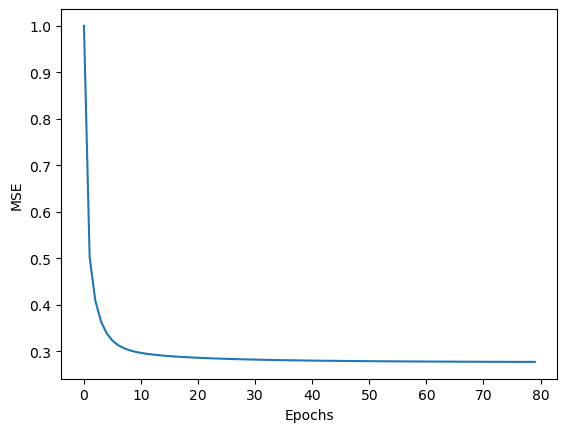

In [151]:
cost = linReg.cost
plt.plot(range(len(cost)), cost)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.savefig('pa2_q3_mse_epochs.png')
plt.show()

In [152]:
y_pred = linReg.forward(x_test)
print(f'Test Set MSE: {linReg.loss(y_pred, y_test)}')
print(f'Test Set MAE: {linReg.mean_abs_error(y_pred, y_test)}')

Test Set MSE: 0.20421951686682666
Test Set MAE: 0.32926640344199753
